# showus

In [ ]:
#default_exp showus

In [ ]:
! pip install /kaggle/input/nlp-packages/datasets/datasets/fsspec-2021.4.0-py3-none-any.whl
! pip install datasets --no-index --find-links=file:///kaggle/input/coleridge-packages/packages/datasets
! pip install ../input/coleridge-packages/seqeval-1.2.2-py3-none-any.whl
! pip install ../input/coleridge-packages/tokenizers-0.10.1-cp37-cp37m-manylinux1_x86_64.whl
! pip install ../input/coleridge-packages/transformers-4.5.0.dev0-py3-none-any.whl

Processing /kaggle/input/nlp-packages/datasets/datasets/fsspec-2021.4.0-py3-none-any.whl
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.8.7
    Uninstalling fsspec-0.8.7:
      Successfully uninstalled fsspec-0.8.7
Looking in links: file:///kaggle/input/coleridge-packages/packages/datasets
Processing /kaggle/input/coleridge-packages/packages/datasets/datasets-1.5.0-py3-none-any.whl
Processing /kaggle/input/coleridge-packages/packages/datasets/xxhash-2.0.0-cp37-cp37m-manylinux2010_x86_64.whl
Processing /kaggle/input/coleridge-packages/packages/datasets/huggingface_hub-0.0.7-py3-none-any.whl
Processing /kaggle/input/coleridge-packages/packages/datasets/tqdm-4.49.0-py2.py3-none-any.whl
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
      Successfully uninstalled tqdm-4.59.0
Processing /kaggle/input/coleridge-packages/seqeval-1.2.2-py3-none-any.whl
Processing /kaggle/input/coleridge-packages/tokenizers-0.10.

In [ ]:
#export
import os, shutil, time
from tqdm import tqdm
from pathlib import Path
import itertools
from functools import partial
import re
import json
import random
import numpy as np
import pandas as pd
import torch
import transformers, seqeval
from transformers import AutoTokenizer, DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer
from datasets import load_dataset, ClassLabel, load_metric

import matplotlib.pyplot as plt

# Utilities

In [ ]:
#export
Path.ls = lambda pth: list(pth.iterdir())

# Data I/O

In [ ]:
#export
def load_train_meta(pth, group_id=True):
    df = pd.read_csv(pth)
    if group_id:
        df = df.groupby('Id').agg({'pub_title': 'first', 'dataset_title': '|'.join, 
                                   'dataset_label': '|'.join, 'cleaned_label': '|'.join}).reset_index()
    return df

In [ ]:
pth = Path('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv')
df = load_train_meta(pth, group_id=True)
df_nogroup = load_train_meta(pth, group_id=False)
print(len(df), len(df_nogroup))
dup_ids = df_nogroup[df_nogroup.Id.duplicated()].Id.unique()
print(df[df.Id.isin(dup_ids)].dataset_label.values[-10:])

14316 19661
['Baltimore Longitudinal Study of Aging (BLSA)|Baltimore Longitudinal Study of Aging'
 'Beginning Postsecondary Students Longitudinal Study|Education Longitudinal Study|Beginning Postsecondary Students'
 "ADNI|Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 "ADNI|Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 "ADNI|Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 "ADNI|Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 "ADNI|Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 'Baltimore Longitudinal Study of Aging (BLSA)|Baltimore Longitudinal Study of Aging'
 "ADNI|Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 'Beginning Postsecondary Student|Beginning Postsecondary Students']


In [ ]:
#export
def load_papers(dir_json, paper_ids):
    '''
    Load papers into a dictionary.
    
    `papers`: 
        {''}
    '''
    
    papers = {}
    for paper_id in paper_ids:
        with open(f'{dir_json}/{paper_id}.json', 'r') as f:
            paper = json.load(f)
            papers[paper_id] = paper
    return papers

In [ ]:
df = load_train_meta('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv', group_id=True).iloc[-10:]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train/', df.Id)
print(type(papers))
print(
    papers[ np.random.choice(df.Id.values) ][0]
)

<class 'dict'>
{'section_title': '', 'text': 'predicts that tuition and fees at four-year public institutions will double in 17 years, while tuition and fees at two-year publics and four-year privates will double in 23 and 27 years, respectively. To put this in perspective, the cost of tuition and fees at a public four-year university in 17 years will be akin to pulling out about $18,000 today from one\'s pocket. And that\'s just for tuition and fees. Room and board will likely cost another $18,000 to $20,000 by that point. All told, the annual, in-state cost of attendance at a public four-year institution will run about $38,000 in the early 2030s in today\'s dollars. Over a four-year period, this will total about $150,000. Note. Future trend used annual multiplier of 2.6% for private 4-year, 4.3% for public 4-year, and 3.1% for public 2-year colleges to arrive at increases above inflation, based on 25-year historical data.\nJust imagine walking into a college financial aid office tomo

In [ ]:
#export
def load_sample_text(jpth):
    sections = json.loads(jpth.read_text())
    text = '\n'.join(section['text'] for section in sections)
    return text

In [ ]:
jpths_trn = Path('/kaggle/input/coleridgeinitiative-show-us-the-data/train/').ls()
print(load_sample_text(jpths_trn[0])[:1_000])

The International Standard Classification of Education, known by its acronym ISCED, was developed by the United Nations Educational, Scientific, and Cultural Organization during the late 1960s and 1970s. ISCED was implemented in 1976 and is the recognized international standard for reporting and interpreting education program data. Creating a U.S. crosswalk to this system has been a goal of the National Center for Education Statistics and the Office of Research since the late 197,,s, when the National Institute of Education (the predecessor agency to the Office of Educational Research and Improvement) began exploring the idea. The design and implementation of a workable crosswalk, however, awaited the advent of changes to the Classification of Instructional Programs (CIP) system. The 1990 revision of the CIP system laid the foundation for a workable international crosswalk. Adoption of the National Education Goals set global consciousness and international educational comparisons firml

# Data processing

In [ ]:
#export
def clean_training_text(txt, lower=False, total_clean=False):
    """
    similar to the default clean_text function but without lowercasing.
    """
    txt = str(txt).lower() if lower else str(txt)
    txt = re.sub('[^A-Za-z0-9]+', ' ', txt).strip()
    if total_clean:
        txt = re.sub(' +', ' ', txt)
    return txt

In [ ]:
print(clean_training_text('@kaggle This competition awards $90,000!!!!.'))
print(clean_training_text('HoPKLd + 7 ! 11,002', total_clean=True, lower=True))

kaggle This competition awards 90 000
hopkld 7 11 002


In [ ]:
#export
def shorten_sentences(sentences, max_length=64, overlap=20):
    '''
    Args:
        sentences (list): List of sentences.
        max_length (int): Maximum number of words allowed for each sentence.
        overlap (int): If a sentence exceeds `max_length`, we split it to multiple sentences with 
            this amount of overlapping.
    '''
    short_sentences = []
    for sentence in sentences:
        words = sentence.split()
        if len(words) > max_length:
            for p in range(0, len(words), max_length - overlap):
                short_sentences.append(' '.join(words[p:p+max_length]))
        else:
            short_sentences.append(sentence)
    return short_sentences

In [ ]:
jpths_trn = Path('/kaggle/input/coleridgeinitiative-show-us-the-data/train/').ls()
sentences = load_sample_text(jpths_trn[0]).split('.')[:2]
short_sentences = shorten_sentences(sentences, max_length=10, overlap=2)
print('Before:', sentences)
print()
print('After:', short_sentences)

Before: ['The International Standard Classification of Education, known by its acronym ISCED, was developed by the United Nations Educational, Scientific, and Cultural Organization during the late 1960s and 1970s', ' ISCED was implemented in 1976 and is the recognized international standard for reporting and interpreting education program data']

After: ['The International Standard Classification of Education, known by its acronym', 'its acronym ISCED, was developed by the United Nations Educational,', 'Nations Educational, Scientific, and Cultural Organization during the late 1960s', 'late 1960s and 1970s', 'ISCED was implemented in 1976 and is the recognized international', 'recognized international standard for reporting and interpreting education program data', 'program data']


In [ ]:
#export
def find_sublist(big_list, small_list):
    all_positions = []
    for i in range(len(big_list) - len(small_list) + 1):
        if small_list == big_list[i:i+len(small_list)]:
            all_positions.append(i)
    
    return all_positions

In [ ]:
big_list = ['If', 'the', 'thing', 'above', 'is', 'below', 'that', 'thing', 'which', 'is',
            'not', 'as', 'high', 'up', 'on', 'the', 'thing', 'above', 'when', 'it', 'is', 
            'underneath', 'them.']
small_list = ['the', 'thing', 'above']

find_sublist(big_list, small_list)

[1, 15]

# Named Entity Recognition

In [ ]:
#export
def get_ner_classlabel():
    '''
    Labels for named entity recognition.
        'O': Token not part of a phrase that mentions a dataset.
        'I': Intermediate token of a phrase mentioning a dataset.
        'B': First token of a phrase mentioning a dataset.
    '''
    return ClassLabel(names=['O', 'I', 'B'])

In [ ]:
classlabel = get_ner_classlabel()
print(classlabel)
print(classlabel.str2int(['I', 'O', 'B']), classlabel.str2int('I'))
print(classlabel.int2str(2), classlabel.int2str([2, 1, 0]))

ClassLabel(num_classes=3, names=['O', 'I', 'B'], names_file=None, id=None)
[1, 0, 2] 1
B ['B', 'I', 'O']


In [ ]:
#export
def tag_sentence(sentence, labels, classlabel=None): 
    '''
    requirement: both sentence and labels are already cleaned
    '''
    sentence_words = sentence.split()
    
    if labels is not None and any(re.findall(f'\\b{label}\\b', sentence)
                                  for label in labels): # positive sample
        nes = [classlabel.str2int('O')] * len(sentence_words)
        for label in labels:
            label_words = label.split()

            all_pos = find_sublist(sentence_words, label_words)
            for pos in all_pos:
                nes[pos] = classlabel.str2int('B')
                for i in range(pos+1, pos+len(label_words)):
                    nes[i] = classlabel.str2int('I')

        return True, list(zip(sentence_words, nes))
        
    else: # negative sample
        nes = [classlabel.str2int('O')] * len(sentence_words)
        return False, list(zip(sentence_words, nes))

In [ ]:
sentence = ("The International Standard Classification of Education, known by its acronym ISCED, "
            "was developed by the United Nations Educational, "
            "Scientific, and Cultural Organization during the late 1960s and 1970s")
labels = ['The International', 'Cultural Organization', 'United Nations Educational']

sentence = clean_training_text(sentence)
labels = [clean_training_text(label) for label in labels]
classlabel = get_ner_classlabel()
found_any, token_tags = tag_sentence(sentence, labels, classlabel=classlabel)

print('A label is found in the sentence:', found_any)
print('(token, tag) pairs:')
print(token_tags)

A label is found in the sentence: True
(token, tag) pairs:
[('The', 2), ('International', 1), ('Standard', 0), ('Classification', 0), ('of', 0), ('Education', 0), ('known', 0), ('by', 0), ('its', 0), ('acronym', 0), ('ISCED', 0), ('was', 0), ('developed', 0), ('by', 0), ('the', 0), ('United', 2), ('Nations', 1), ('Educational', 1), ('Scientific', 0), ('and', 0), ('Cultural', 2), ('Organization', 1), ('during', 0), ('the', 0), ('late', 0), ('1960s', 0), ('and', 0), ('1970s', 0)]


In [ ]:
#export
def extract_sentences(paper, sentence_definition='sentence'):
    if sentence_definition == 'sentence':
        sentences = set(clean_training_text(sentence) 
                        for sec in paper for sentence in sec['text'].split('.') if sec['text'])
    elif sentence_definition == 'section':
        sentences = set(clean_training_text(sec['section_title'] + '\n' + sec['text']) 
                        for sec in paper if sec['text'])
    return sentences

In [ ]:
df = load_train_meta('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv', group_id=True).iloc[100:110]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train', df.Id)
paper = papers[df.Id.iloc[3]]
print('..... Sentence definition = normal sentence')
sentences = extract_sentences(paper, sentence_definition='sentence')
print(len(sentences), list(sentences)[:2], end='\n\n')
print('..... Sentence definition = paper section')
sentences = extract_sentences(paper, sentence_definition='section')
print(len(sentences), list(sentences)[:2][:1_000], end='\n\n')

..... Sentence definition = normal sentence
302 ['', 'These schools which are disproportionately rural are thus excluded from the analysis']

..... Sentence definition = paper section
12 ['Introduction School choice has become one of the most contentious public policy debates in the United States', 'IV panel models This elasticity might seem small at first blush but recall that it is conditional on the previous year performance composite The average performance composite gain in 1999 2000 for example is 1 11 points 1 7 percent so ignoring statistical significance halving the distance to the nearest charter would bring about an increase of just less than ten percent of the average achievement gain Models 2 through 6 control for charter school competition using indicators for whether a charter school was operating within a given distance In all of these models charter school competition raises the performance composite of the traditional school The effect is significant at standard signi

In [ ]:
#export
def get_paper_ner_data(paper, labels, classlabel=None,
                       sentence_definition='sentence', max_length=64, overlap=20):
    '''
    Get NER data for a single paper.
    '''
    labels = [clean_training_text(label) for label in labels]
    sentences = extract_sentences(paper, sentence_definition=sentence_definition)
    sentences = shorten_sentences(sentences, max_length=max_length, overlap=overlap) 
    sentences = [sentence for sentence in sentences if len(sentence) > 10] # only accept sentences with length > 10 chars

    cnt_pos, cnt_neg, ner_data = 0, 0, []
    for sentence in sentences:
        is_positive, tags = tag_sentence(sentence, labels, classlabel=classlabel)
        if is_positive:
            cnt_pos += 1
            ner_data.append(tags)
        elif any(word in sentence.lower() for word in ['data', 'study']): 
            ner_data.append(tags)
            cnt_neg += 1    
    return cnt_pos, cnt_neg, ner_data

In [ ]:
df = load_train_meta('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv', group_id=True).iloc[230:240]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train/', df.Id)
classlabel = get_ner_classlabel()

idx = 8
paper = papers[df.Id.iloc[idx]]
labels = df.dataset_label.iloc[idx].split('|')
cnt_pos, cnt_neg, ner_data = get_paper_ner_data(paper, labels, classlabel=classlabel,
                                                sentence_definition='section', max_length=512, overlap=20)
print(cnt_pos, cnt_neg)
print([len(sec) for sec in ner_data])
print(ner_data[-2])

9 1
[101, 512, 512, 49, 303, 512, 512, 512, 512, 259]
[('that', 0), ('they', 0), ('never', 0), ('disclosed', 0), ('amyloid', 0), ('imaging', 0), ('results', 0), ('to', 0), ('participants', 0), ('with', 0), ('normal', 0), ('cognition', 0), ('Most', 0), ('respondents', 0), ('127', 0), ('139', 0), ('91', 0), ('answered', 0), ('that', 0), ('they', 0), ('did', 0), ('not', 0), ('use', 0), ('ADNI', 2), ('results', 0), ('to', 0), ('inform', 0), ('a', 0), ('participant', 0), ('who', 0), ('has', 0), ('MCI', 0), ('whether', 0), ('he', 0), ('or', 0), ('she', 0), ('is', 0), ('at', 0), ('increased', 0), ('or', 0), ('decreased', 0), ('risk', 0), ('of', 0), ('developing', 0), ('AD', 0), ('dementia', 0), ('The', 0), ('respondents', 0), ('who', 0), ('did', 0), ('use', 0), ('results', 0), ('12', 0), ('139', 0), ('9', 0), ('typically', 0), ('used', 0), ('neuropsychometrics', 0), ('and', 0), ('brain', 0), ('MRI', 0), ('but', 0), ('a', 0), ('few', 0), ('reported', 0), ('using', 0), ('PET', 0), ('amyloid', 0

In [ ]:
#export
def get_ner_data(papers, df=None, classlabel=None, shuffle=True, 
                 sentence_definition='sentence', max_length=64, overlap=20):
    '''
    Get NER data for a list of papers.
    
    Args:
        papers (dict): Like that returned by `load_papers`.
        df (pd.DataFrame): Competition's train.csv or a subset of it.
    Returns:
        cnt_pos (int): Number of samples (or 'sentences') that are tagged or partly
            tagged as datasets.
        cnt_neg (int): Number of samples (or 'sentences') that are not tagged
            or partly tagged as datasets.
        ner_data (list): List of samples, or 'sentences'. Each element is of the form:
            [('There', 0), ('has', 0), ('been', 0), ...]
    '''
    cnt_pos, cnt_neg = 0, 0 
    ner_data = []

    tqdm._instances.clear()
    pbar = tqdm(total=len(df))
    for i, id, dataset_label in df[['Id', 'dataset_label']].itertuples():
        paper = papers[id]
        labels = dataset_label.split('|')
                
        cnt_pos_, cnt_neg_, ner_data_ = get_paper_ner_data(
            paper, labels, classlabel=classlabel, 
            sentence_definition=sentence_definition, max_length=max_length, overlap=overlap)
        cnt_pos += cnt_pos_
        cnt_neg += cnt_neg_
        ner_data.extend(ner_data_)

        pbar.update(1)
        pbar.set_description(f"Training data size: {cnt_pos} positives + {cnt_neg} negatives")

    if shuffle:
        random.shuffle(ner_data)
    return cnt_pos, cnt_neg, ner_data

In [ ]:
%%time
df = pd.read_csv('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv').iloc[:10]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train/', df.Id)
classlabel = get_ner_classlabel()
cnt_pos, cnt_neg, ner_data = get_ner_data(papers, df, classlabel=classlabel, shuffle=False,
                                          sentence_definition='sentence', max_length=64, overlap=20)
print(f'Postive count: {cnt_pos}.   Negative count: {cnt_neg}')
print(ner_data[250])

Training data size: 29 positives + 223 negatives: 100%|██████████| 10/10 [00:00<00:00, 176.23it/s]

Postive count: 29.   Negative count: 223
[('These', 0), ('works', 0), ('include', 0), ('Coleman', 0), ('and', 0), ('Hoffer', 0), ('s', 0), ('findings', 0), ('regarding', 0), ('the', 0), ('social', 0), ('capital', 0), ('and', 0), ('functional', 0), ('community', 0), ('of', 0), ('Catholic', 0), ('schools', 0), ('Chubb', 0), ('and', 0), ('Moe', 0), ('s', 0), ('conclusions', 0), ('regarding', 0), ('the', 0), ('climate', 0), ('of', 0), ('collegiality', 0), ('and', 0), ('empowerment', 0), ('in', 0), ('Catholic', 0), ('schools', 0), ('the', 0), ('Rand', 0), ('study', 0), ('s', 0), ('focus', 0), ('on', 0), ('clarity', 0), ('of', 0), ('mission', 0), ('and', 0), ('local', 0), ('ownership', 0), ('by', 0), ('educators', 0), ('students', 0), ('and', 0), ('parents', 0), ('and', 0), ('Bryk', 0), ('Lee', 0), ('and', 0), ('Holland', 0), ('s', 0), ('emphasis', 0), ('on', 0), ('Catholic', 0), ('schools', 0), ('as', 0), ('voluntary', 0), ('communities', 0)]
CPU times: user 112 ms, sys: 6.99 ms, total: 119

In [ ]:
%%time
df = pd.read_csv('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv').iloc[:10]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train/', df.Id)
classlabel = get_ner_classlabel()
cnt_pos, cnt_neg, ner_data = get_ner_data(papers, df, classlabel=classlabel, shuffle=False, 
                                          sentence_definition='section', max_length=512, overlap=20)
print(f'Postive count: {cnt_pos}.   Negative count: {cnt_neg}')
print(ner_data[3])

Training data size: 27 positives + 70 negatives: 100%|██████████| 10/10 [00:00<00:00, 212.82it/s]

Postive count: 27.   Negative count: 70
[('Reason', 0), ('for', 0), ('review', 0), ('This', 0), ('study', 0), ('was', 0), ('identified', 0), ('for', 0), ('review', 0), ('by', 0), ('receiving', 0), ('media', 0), ('attention', 0)]
CPU times: user 102 ms, sys: 11.4 ms, total: 113 ms
Wall time: 113 ms


In [ ]:
#export
def write_ner_json(ner_data, pth=Path('train_ner.json')):
    '''
    Save NER data to json file.
    '''
    with open(pth, 'w') as f:
        for row in ner_data:
            words, nes = list(zip(*row))
            row_json = {'tokens' : words, 'ner_tags' : nes}
            json.dump(row_json, f)
            f.write('\n')    

In [ ]:
ner_data = [
    [('There', 0), ('is', 0), ('no', 0), ('dataset', 0), ('here', 0)], 
    [('Load', 0), ('the', 0), ('UN', 2), ('Trade', 1), ('Development', 1), ('into', 0), ('view', 0)]
]
write_ner_json(ner_data, pth=Path('/kaggle/tmp_ner.json'))
! cat /kaggle/tmp_ner.json

{"tokens": ["There", "is", "no", "dataset", "here"], "ner_tags": [0, 0, 0, 0, 0]}
{"tokens": ["Load", "the", "UN", "Trade", "Development", "into", "view"], "ner_tags": [0, 0, 2, 1, 1, 0, 0]}


In [ ]:
#export
def load_ner_datasets(data_files=None):
    '''
    Load NER data in json files to a `datasets` object.  In addition,
    Append the NER ClassLabel for the `ner_tags` feature.
    '''
    datasets = load_dataset('json', data_files=data_files)
    classlabel = get_ner_classlabel()
    for split, dataset in datasets.items():
        dataset.features['ner_tags'].feature = classlabel
    return datasets

In [ ]:
datasets = load_ner_datasets(data_files={'train':'/kaggle/tmp_ner.json', 'valid':'/kaggle/tmp_ner.json'})
print()
print(datasets['valid'].features)
print(datasets['train'][1])

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-8e0e9dfcb90f91ef/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(num_classes=3, names=['O', 'I', 'B'], names_file=None, id=None), length=-1, id=None)}
{'tokens': ['Load', 'the', 'UN', 'Trade', 'Development', 'into', 'view'], 'ner_tags': [0, 0, 2, 1, 1, 0, 0]}


In [ ]:
#export
def create_tokenizer(model_checkpoint='distilbert-base-cased'):
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)
    return tokenizer

In [ ]:
tokenizer = create_tokenizer(model_checkpoint='distilbert-base-cased')
print(
    tokenizer("A smattering of people descended from the midday boat on Monday."))
print()
print(
    tokenizer("Giglio boasts several pristine bays with crystal clear water".split(), is_split_into_words=True)
)


{'input_ids': [101, 138, 188, 21943, 9930, 1104, 1234, 9026, 1121, 1103, 2286, 6194, 3499, 1113, 6356, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

{'input_ids': [101, 144, 6512, 9436, 24372, 1317, 185, 12937, 2042, 15520, 1114, 8626, 2330, 1447, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
sentence = "A smattering of people descended from the midday boat on Monday.".split()
tokenized_sentence = tokenizer(sentence, is_split_into_words=True)

print(sentence)
print(tokenized_sentence.word_ids())
print(tokenizer.convert_ids_to_tokens(tokenized_sentence['input_ids']))

['A', 'smattering', 'of', 'people', 'descended', 'from', 'the', 'midday', 'boat', 'on', 'Monday.']
[None, 0, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, None]
['[CLS]', 'A', 's', '##mat', '##tering', 'of', 'people', 'descended', 'from', 'the', 'mid', '##day', 'boat', 'on', 'Monday', '.', '[SEP]']


Training data size: 213 positives + 1298 negatives: 100%|██████████| 100/100 [00:00<00:00, 115.49it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-8fdd034c72bd9959/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


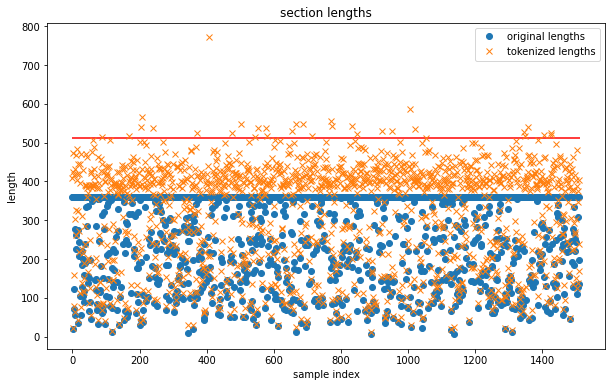

In [ ]:
# Find a suitable original sample length, given a max model input length of 512

max_input_length = 512
max_length, overlap = 360, 20

df = load_train_meta('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv', group_id=True)
df = df.sample(100).reset_index(drop=True)
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train', df.Id)
classlabel = get_ner_classlabel()
cnt_pos, cnt_neg, ner_data = get_ner_data(papers, df, classlabel=classlabel, 
                                          sentence_definition='section', max_length=max_length, overlap=overlap)
write_ner_json(ner_data, pth='train_ner.json')

datasets = load_ner_datasets(data_files={'train':'train_ner.json'})

tokenizer = create_tokenizer(model_checkpoint='distilbert-base-cased')

tokenized_input = tokenizer(datasets['train']['tokens'], truncation=False, is_split_into_words=True)

original_sample_lengths = np.array([len(tokens) for tokens in datasets['train']['tokens']])
tokenized_sample_lengths = np.array([len(input_ids) for input_ids in tokenized_input['input_ids']])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(original_sample_lengths, label='original lengths', linestyle='none', marker='o')
ax.plot(tokenized_sample_lengths, label='tokenized lengths', linestyle='none', marker='x')
ax.hlines(y=max_input_length, xmin=0, xmax=len(original_sample_lengths), color='red')
ax.set_ylabel('length')
ax.set_xlabel('sample index')
ax.set_title('section lengths')
ax.legend()

In [ ]:
#export
def tokenize_and_align_labels(examples, tokenizer=None, label_all_tokens=True):
    '''
    Adds a new field called 'labels' that are the NER tags to the tokenized input.
    
    Args:
        tokenizer (transformers.AutoTokenizer): Tokenizer.
        examples (datasets.arrow_dataset.Dataset): Dataset.
        label_all_tokens (bool): If True, all sub-tokens are given the same tag as the 
            first sub-token, otherwise all but the first sub-token are given the tag
            -100.
    '''
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    word_ids_all = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)
        word_ids_all.append(word_ids)

    tokenized_inputs["labels"] = labels
    tokenized_inputs['word_ids'] = word_ids_all
    return tokenized_inputs

In [ ]:
datasets = load_ner_datasets(data_files={'train':'/kaggle/tmp_ner.json', 'valid':'/kaggle/tmp_ner.json'})
tokenizer = create_tokenizer(model_checkpoint='bert-base-cased')

! cat /kaggle/tmp_ner.json

print()
print(tokenize_and_align_labels(datasets['train'][:], tokenizer, label_all_tokens=True), end='\n\n')

tokenized_datasets = datasets.map(
    partial(tokenize_and_align_labels, tokenizer=tokenizer, label_all_tokens=True), batched=True)
print(tokenized_datasets['valid'][:])
print(tokenized_datasets['train'].features)

Training data size: 213 positives + 1298 negatives: 100%|██████████| 100/100 [00:11<00:00, 115.49it/s]


{"tokens": ["There", "is", "no", "dataset", "here"], "ner_tags": [0, 0, 0, 0, 0]}
{"tokens": ["Load", "the", "UN", "Trade", "Development", "into", "view"], "ner_tags": [0, 0, 2, 1, 1, 0, 0]}

{'input_ids': [[101, 1247, 1110, 1185, 2233, 9388, 1303, 102], [101, 10605, 3556, 1103, 7414, 5820, 3273, 1154, 2458, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 0, 0, 0, 0, 0, 0, -100], [-100, 0, 0, 0, 2, 1, 1, 0, 0, -100]], 'word_ids': [[None, 0, 1, 2, 3, 3, 4, None], [None, 0, 0, 1, 2, 3, 4, 5, 6, None]]}




{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'input_ids': [[101, 1247, 1110, 1185, 2233, 9388, 1303, 102], [101, 10605, 3556, 1103, 7414, 5820, 3273, 1154, 2458, 102]], 'labels': [[-100, 0, 0, 0, 0, 0, 0, -100], [-100, 0, 0, 0, 2, 1, 1, 0, 0, -100]], 'ner_tags': [[0, 0, 0, 0, 0], [0, 0, 2, 1, 1, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'tokens': [['There', 'is', 'no', 'dataset', 'here'], ['Load', 'the', 'UN', 'Trade', 'Development', 'into', 'view']], 'word_ids': [[None, 0, 1, 2, 3, 3, 4, None], [None, 0, 0, 1, 2, 3, 4, 5, 6, None]]}
{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(num_classes=3, names=['O', 'I', 'B'], names_file=None, id=None), length=-1, id=None), 'token_

In [ ]:
# Save and load `datasets.dataset_dict.DatasetDict`
tokenized_datasets.save_to_disk('testsave_datasets')

In [ ]:
print(datasets.load_from_disk('testsave_datasets')['train']['input_ids'])
print(tokenized_datasets['train']['input_ids'])

[[101, 1247, 1110, 1185, 2233, 9388, 1303, 102], [101, 10605, 3556, 1103, 7414, 5820, 3273, 1154, 2458, 102]]
[[101, 1247, 1110, 1185, 2233, 9388, 1303, 102], [101, 10605, 3556, 1103, 7414, 5820, 3273, 1154, 2458, 102]]


In [ ]:
metric = load_metric('seqeval')

predictions = np.array([['O', 'O', 'B', 'I', 'I', 'O']])
references = [['O', 'O', 'B', 'I', 'I', 'O']]
print(metric.compute(predictions=predictions, references=references))

predictions = [['O', 'O', 'B', 'I', 'I', 'O']]
references = [['B', 'I', 'I', 'O', 'O', 'O']]
print(metric.compute(predictions=predictions, references=references))


{'_': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1}, 'overall_precision': 1.0, 'overall_recall': 1.0, 'overall_f1': 1.0, 'overall_accuracy': 1.0}
{'_': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1}, 'overall_precision': 0.0, 'overall_recall': 0.0, 'overall_f1': 0.0, 'overall_accuracy': 0.16666666666666666}


In [ ]:
#export
def jaccard_similarity(s1, s2):
    l1 = set(s1.split(" "))
    l2 = set(s2.split(" "))
    intersection = len(list(l1.intersection(l2)))
    union = (len(l1) + len(l2)) - intersection
    return float(intersection) / union

In [ ]:
jaccard_similarity('USGS Frog Counts Data', 'USGA Croc Counts Data') == 1 / 3

True

In [ ]:
#export
def remove_nonoriginal_outputs(outputs, word_ids):
    '''
    Remove elements that correspond to special tokens or subtokens,
    retaining only those elements that correspond to a word in original
    text.
    
    Args:
        outputs (np.array): 
        
    Returns:
        outputs (list)
    '''
    assert len(outputs) == len(word_ids)
    idxs = [[word_id.index(i) for i in set(word_id) if i is not None] 
            for word_id in word_ids]
    outputs = [output[idx].tolist() for output, idx in zip(outputs, idxs)]
    for output in outputs:
        assert -100 not in output
    return outputs

In [ ]:
classlabel = get_ner_classlabel()

predictions = np.random.randn(2, 8, classlabel.num_classes)
predictions = np.argmax(predictions, axis=2)

label_ids = np.array([[-100, 0, 0,    2, 1,    2,    1, -100],
                      [-100, 2, 1, -100, 0, -100, -100, -100]])

word_ids = [[None, 0, 0, 1, 2, None],
            [None, 0, 1, 1, 2, 2, None]]

true_predictions = remove_nonoriginal_outputs(predictions, word_ids)
true_label_ids   = remove_nonoriginal_outputs(label_ids,   word_ids)

print('predictions')
print('BEFORE:')
print(predictions)
print('AFTER:')
print(true_predictions)
print(60 * '=')
print('label_ids')
print('BEFORE:')
print(label_ids)
print('AFTER:')
print(true_label_ids)

predictions
BEFORE:
[[2 2 2 0 0 0 2 2]
 [2 2 1 1 0 1 1 2]]
AFTER:
[[2, 0, 0], [2, 1, 0]]
label_ids
BEFORE:
[[-100    0    0    2    1    2    1 -100]
 [-100    2    1 -100    0 -100 -100 -100]]
AFTER:
[[0, 2, 1], [2, 1, 0]]


In [ ]:
#export
def compute_metrics(p, metric=None, word_ids=None, label_list=None):
    '''
    1. Remove predicted and ground-truth class ids of special and sub tokens.
    2. Convert class ids to class labels. (int ---> str)
    3. Compute metric.
    
    Args:
        p (tuple): 2-tuple consisting of model prediction and ground-truth
            labels.  These will contain elements corresponding to special 
            tokens and sub-tokens.
        word_ids (list): Word IDs from the tokenizer's output, indicating
            which original word each sub-token belongs to.
    '''
    predictions, label_ids = p
    predictions = predictions.argmax(axis=2)

    true_predictions = remove_nonoriginal_outputs(predictions, word_ids)
    true_label_ids = remove_nonoriginal_outputs(label_ids, word_ids)
#     true_predictions = [[p for p, l, in zip(pred, label) if l != -100] 
#                         for pred, label in zip(predictions, label_ids)]
#     true_label_ids   = [[l for l in label if l != -100] for label in label_ids]
    
    true_predictions = [[label_list[p] for p in pred] for pred in true_predictions]
    true_labels = [[label_list[i] for i in label_id] for label_id in true_label_ids]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
batch_size = 2
max_example_length = 6

predictions = np.random.randn(batch_size, max_example_length, classlabel.num_classes)
label_ids = np.random.randint(low=0, high=classlabel.num_classes, 
                              size=(batch_size, max_example_length), dtype=np.int16)
word_ids = [[None, 0, 0, 1, 2, None], 
            [None, 0, 1, None]]

print(predictions.argmax(axis=2))
print(label_ids)
p = (predictions, label_ids)
metric = load_metric('seqeval')
compute_metrics(p, metric=metric, label_list=classlabel.names, word_ids=word_ids)

[[1 0 0 2 0 1]
 [2 2 1 1 1 1]]
[[2 2 1 2 0 1]
 [2 2 0 1 2 0]]


{'precision': 0.5, 'recall': 0.3333333333333333, 'f1': 0.4, 'accuracy': 0.6}

## NER training

In [ ]:
train_meta = load_train_meta('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv').iloc[:3]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train', train_meta.Id)

valid_cutoff = int(.50 * len(train_meta))
valid_meta = train_meta.iloc[:valid_cutoff].reset_index(drop=True)
train_meta = train_meta.iloc[valid_cutoff:].reset_index(drop=True)

classlabel = get_ner_classlabel()
train_cnt_pos, train_cnt_neg, train_ner_data = get_ner_data(
    papers, df=train_meta, classlabel=classlabel, sentence_definition='section', max_length=360, overlap=20)
valid_cnt_pos, valid_cnt_neg, valid_ner_data = get_ner_data(
    papers, df=valid_meta, classlabel=classlabel, sentence_definition='section', max_length=360, overlap=20)
print(f'Train.  Positive count: {train_cnt_pos}.  Negative count: {train_cnt_neg}.')
print(f'Valid.  Positive count: {valid_cnt_pos}.  Negative count: {valid_cnt_neg}.')

write_ner_json(train_ner_data, pth='train_ner.json')
write_ner_json(valid_ner_data, pth='valid_ner.json')
datasets = load_ner_datasets(data_files={'train':'train_ner.json', 'valid':'valid_ner.json'})

model_checkpoint = 'distilbert-base-cased'
tokenizer = create_tokenizer(model_checkpoint)
tokenized_datasets = datasets.map(
    partial(tokenize_and_align_labels, tokenizer=tokenizer, label_all_tokens=True), batched=True)

tokenized_datasets.save_to_disk(f'datasetdict_{model_checkpoint}')

Training data size: 1 positives + 12 negatives: 100%|██████████| 1/1 [00:00<00:00, 171.11it/s]

Train.  Positive count: 3.  Negative count: 29.
Valid.  Positive count: 1.  Negative count: 12.


Training data size: 1 positives + 12 negatives: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s] 


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-62a96df54c9a6706/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.


In [ ]:
model_checkpoint = 'distilbert-base-cased'
tokenizer = create_tokenizer(model_checkpoint)
tokenized_datasets = datasets.load_from_disk(f'datasetdict_{model_checkpoint}')
data_collator = DataCollatorForTokenClassification(tokenizer)

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=classlabel.num_classes)

metric = load_metric('seqeval')
word_ids = tokenized_datasets['valid']['word_ids']
compute_metrics_ = partial(compute_metrics, metric=metric, label_list=classlabel.names, word_ids=word_ids)

args = TrainingArguments(output_dir='test_training', num_train_epochs=2, 
                         learning_rate=2e-5, weight_decay=0.01,
                         per_device_train_batch_size=16, per_device_eval_batch_size=16,
                         evaluation_strategy='epoch', logging_steps=4, report_to='none', 
                         save_strategy='epoch', save_total_limit=6)

trainer = Trainer(model=model, args=args, 
                  train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['valid'], 
                  data_collator=data_collator, tokenizer=tokenizer, compute_metrics=compute_metrics_)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Runtime,Samples Per Second
1,No log,0.800264,0.000000,0.000000,0.000000,0.923909,6.605700,1.968000
2,0.882500,0.655518,0.000000,0.000000,0.000000,0.988810,6.632400,1.960000


TrainOutput(global_step=4, training_loss=0.8824873566627502, metrics={'train_runtime': 131.1307, 'train_samples_per_second': 0.031, 'total_flos': 10601982046656.0, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 5282013184, 'train_mem_cpu_peaked_delta': 2429173760})

In [ ]:
! ls -lrt test_training

total 8
drwxr-xr-x 2 root root 4096 Jun  7 04:57 checkpoint-2
drwxr-xr-x 2 root root 4096 Jun  7 04:58 checkpoint-4


In [ ]:
args = TrainingArguments(output_dir='test_training', num_train_epochs=4, 
                         learning_rate=2e-5, weight_decay=0.01,
                         per_device_train_batch_size=16, per_device_eval_batch_size=16,
                         evaluation_strategy='epoch', logging_steps=4, report_to='none', 
                         save_strategy='epoch', save_total_limit=6)

trainer = Trainer(model=model, args=args, 
                  train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['valid'], 
                  data_collator=data_collator, tokenizer=tokenizer, 
                  compute_metrics=compute_metrics_)
trainer.train(resume_from_checkpoint='/kaggle/working/test_training/checkpoint-4/')

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Runtime,Samples Per Second
3,0.882500,0.585674,0.000000,0.000000,0.000000,0.994405,6.643900,1.957000
4,0.539500,0.517904,0.000000,0.000000,0.000000,0.996643,6.610200,1.967000


TrainOutput(global_step=8, training_loss=0.26974764466285706, metrics={'train_runtime': 127.7453, 'train_samples_per_second': 0.063, 'total_flos': 21203964093312.0, 'epoch': 4.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 2101370880, 'train_mem_cpu_peaked_delta': 1175662592})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5179044008255005,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_accuracy': 0.9966430436404327,
 'eval_runtime': 6.6851,
 'eval_samples_per_second': 1.945,
 'epoch': 4.0,
 'eval_mem_cpu_alloc_delta': -1020305408,
 'eval_mem_cpu_peaked_delta': 1020305408}

## NER inference

**Turn off the Internet here**

In [ ]:
#export
def get_ner_inference_data(papers, sample_submission, classlabel=None, 
                           sentence_definition='sentence', max_length=64, overlap=20):
    '''
    Args:
        papers (dict): Each list in this dictionary consists of the section of a paper.
        sample_submission (pd.DataFrame): Competition 'sample_submission.csv'.
    Returns:
        test_rows (list): Each list in this list is of the form: 
             [('goat', 0), ('win', 0), ...] and represents a sentence.  
        paper_length (list): Number of sentences in each paper.
    '''
    test_rows = [] 
    paper_length = [] 

    for paper_id in sample_submission['Id']:
        paper = papers[paper_id]

        sentences = extract_sentences(paper, sentence_definition=sentence_definition)
        sentences = shorten_sentences(sentences, max_length=max_length, overlap=overlap)
        sentences = [sentence for sentence in sentences if len(sentence) > 10] 
        sentences = [sentence for sentence in sentences 
                     if any(word in sentence.lower() for word in ['data', 'study'])]

        for sentence in sentences:
            sentence_words = sentence.split()
            dummy_tags = [classlabel.str2int('O')]*len(sentence_words)
            test_rows.append(list(zip(sentence_words, dummy_tags)))

        paper_length.append(len(sentences))

    print(f'total number of "sentences": {len(test_rows)}')
    return test_rows, paper_length

In [ ]:
sample_submission = pd.read_csv('/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/test', sample_submission.Id)
classlabel = get_ner_classlabel()
test_rows, paper_length = get_ner_inference_data(papers, sample_submission, classlabel=classlabel, 
                                                 sentence_definition='section', max_length=300, overlap=100)
print(test_rows[1])
print(paper_length)

total number of "sentences": 182
[('Methods', 0), ('and', 0), ('Materials', 0), ('COGENT', 0), ('is', 0), ('an', 0), ('international', 0), ('GWAS', 0), ('collaboration', 0), ('formed', 0), ('to', 0), ('conduct', 0), ('genetic', 0), ('analyses', 0), ('of', 0), ('g', 0), ('and', 0), ('related', 0), ('neurocognitive', 0), ('processes', 0), ('in', 0), ('healthy', 0), ('individuals', 0), ('Donohoe', 0), ('et', 0), ('al', 0), ('2012', 0), ('Though', 0), ('common', 0), ('GWAS', 0), ('markers', 0), ('have', 0), ('been', 0), ('proposed', 0), ('to', 0), ('account', 0), ('for', 0), ('30', 0), ('or', 0), ('more', 0), ('of', 0), ('the', 0), ('variance', 0), ('in', 0), ('general', 0), ('intelligence', 0), ('in', 0), ('adults', 0), ('individual', 0), ('SNPs', 0), ('only', 0), ('contribute', 0), ('a', 0), ('small', 0), ('fraction', 0), ('of', 0), ('the', 0), ('variance', 0), ('to', 0), ('the', 0), ('heritability', 0), ('of', 0), ('g', 0), ('due', 0), ('to', 0), ('extreme', 0), ('polygenicity', 0), ('M

In [ ]:
#export
def ner_predict(pth=None, tokenizer=None, model=None, metric=None):
    classlabel = get_ner_classlabel()
    datasets = load_ner_datasets(data_files={'test':pth})

    print('Tokenizing testset...', end='')
    t0 = time.time()
    tokenized_datasets = datasets.map(
        partial(tokenize_and_align_labels,tokenizer=tokenizer, label_all_tokens=True), 
        batched=True)
    print(f'completed in {(time.time() - t0) / 60:.2f} mins.')
    
    print('Creating data collator...')
    data_collator = DataCollatorForTokenClassification(tokenizer)
    
    print('Creating (dummy) training arguments...')
    args = TrainingArguments(output_dir='test_ner', num_train_epochs=3, 
                             learning_rate=2e-5, weight_decay=0.01,
                             per_device_train_batch_size=16, per_device_eval_batch_size=16,
                             evaluation_strategy='epoch', logging_steps=4, report_to='none', 
                             save_strategy='epoch', save_total_limit=6)

    print('Creating trainer...')
    word_ids = tokenized_datasets['test']['word_ids']
    compute_metrics_ = partial(compute_metrics, metric=metric, label_list=classlabel.names, word_ids=word_ids)
    trainer = Trainer(model=model, args=args, 
                      train_dataset=tokenized_datasets['test'], eval_dataset=tokenized_datasets['test'], 
                      data_collator=data_collator, tokenizer=tokenizer, compute_metrics=compute_metrics_)

    print('Predicting on test samples...')
    t0 = time.time()
    predictions, label_ids, _ = trainer.predict(tokenized_datasets['test'])
    print(f'completed in {(time.time() - t0) / 60:.2f} mins.')
    print('Argmaxing...')
    t0 = time.time()
    predictions = predictions.argmax(axis=2)
    print(f'completed in {(time.time() - t0) / 60:.2f} mins.')
    
    print('Removing non-original outputs...', end='')
    t0 = time.time()
    predictions = remove_nonoriginal_outputs(predictions, word_ids)
    label_ids   = remove_nonoriginal_outputs(label_ids, word_ids)
    print(f'completed in {(time.time() - t0) / 60:.2f} mins.')
    
    return predictions, label_ids

In [ ]:
# This shows where to look for the cached metric `seqeval`.
# metric = load_metric('/root/.cache/huggingface/modules/datasets_modules/metrics/seqeval/ec5b7242a8c40468d189ca0b2b10612578dbcad311b2a134c99e3ded58a0d6e3/seqeval.py')

# Exporting the cached metric 

# %cd /root/.cache
# ! zip -r huggingface_cache.zip huggingface/modules/datasets_modules/metrics/seqeval/ec5b7242a8c40468d189ca0b2b10612578dbcad311b2a134c99e3ded58a0d6e3/
# %cd 

In [ ]:
model_checkpoint = 'test_training/checkpoint-4/'

tokenizer = create_tokenizer(model_checkpoint=model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)
# metric = load_metric('seqeval')
metric = load_metric('/root/.cache/huggingface/modules/datasets_modules/metrics/seqeval/ec5b7242a8c40468d189ca0b2b10612578dbcad311b2a134c99e3ded58a0d6e3/seqeval.py')

In [ ]:
samples = ['''Archaeologists estimate the carvings are between 4,000 and 5,000 years old''', 
           ('''I could see that I was looking at a deer stag upside down, '''
            '''and as I continued looking around, more animals appeared on the rock,” he said.''')]
test_rows = [list(zip(sample.split(), len(sample.split()) * [0])) for sample in samples]
write_ner_json(test_rows, pth='test_ner.json')

predictions, label_ids = ner_predict(pth='test_ner.json', tokenizer=tokenizer, model=model, metric=metric)
for i in range(len(predictions)):
    print(f'Sample {i}:', len(predictions[i]), len(label_ids[i]), len(samples[i].split()))

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-1afb76c1b8da1c43/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.
Tokenizing testset...


completed in 0.00 mins.
Creating data collator...
Creating (dummy) training arguments...
Creating trainer...
Predicting on test samples...


completed in 0.01 mins.
Argmaxing...
completed in 0.00 mins.
Removing non-original outputs...completed in 0.00 mins.
Sample 0: 11 11 11
Sample 1: 27 27 27


/opt/conda/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#export

def batched_ner_predict(pth, tokenizer=None, model=None, metric=None, 
                        batch_size=16):
    '''
    Do inference on dataset in batches.
    '''
    lines = open(pth, mode='r').readlines()
    
    pth_tmp = 'ner_predict_tmp.json'
    predictions, label_ids = [], []
    for ib in range(0, len(lines), batch_size):
        with open(pth_tmp, mode='w') as f:
            f.writelines(lines[ ib: ib + batch_size ])

        predictions_, label_ids_ = ner_predict(
            pth_tmp, tokenizer=tokenizer, model=model, metric=metric)
        predictions.extend(predictions_)
        label_ids.extend(label_ids_)
    return predictions, label_ids

In [ ]:
samples = ['''Archaeologists estimate the carvings are between 4,000 and 5,000 years old''', 
           ('''I could see that I was looking at a deer stag upside down, '''
            '''and as I continued looking around, more animals appeared on the rock,” he said.'''),
           '''The RNN model we are about to build has LSTM cells as basic hidden units.''', 
           '''YouTube series, the Crooner Sessions. Now he gets his musical pals together in real life for ''']
test_rows = [list(zip(sample.split(), len(sample.split()) * [0])) for sample in samples]
write_ner_json(test_rows, pth='test_ner.json')

predictions, label_ids = batched_ner_predict(
    'test_ner.json', tokenizer=tokenizer, model=model, metric=metric, batch_size=2)
    
for i in range(len(predictions)):
    print(f'Sample {i}:', len(predictions[i]), len(label_ids[i]), len(samples[i].split()))

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-79a1817f109f07db/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.
Tokenizing testset...


completed in 0.00 mins.
Creating data collator...
Creating (dummy) training arguments...
Creating trainer...
Predicting on test samples...


completed in 0.01 mins.
Argmaxing...
completed in 0.00 mins.
Removing non-original outputs...completed in 0.00 mins.


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-8c702448f37b85fe/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.
Tokenizing testset...


completed in 0.00 mins.
Creating data collator...
Creating (dummy) training arguments...
Creating trainer...
Predicting on test samples...


completed in 0.01 mins.
Argmaxing...
completed in 0.00 mins.
Removing non-original outputs...completed in 0.00 mins.
Sample 0: 11 11 11
Sample 1: 27 27 27
Sample 2: 15 15 15
Sample 3: 16 16 16


In [ ]:
#export
def get_paper_dataset_labels(pth, paper_length, predictions):
    '''
    Args:
        pth (Path, str): Path to json file containing NER data.  Each row is 
            of form: {'tokens': ['Studying', 'human'], 'ner_tags': [0, 0, ...]}.
    
    Returns:
        paper_dataset_labels (list): Each element is a set consisting of labels predicted
            by the model.
    '''
    test_sentences = [json.loads(sample)['tokens'] for sample in open(pth).readlines()]
    
    paper_dataset_labels = [] # store all dataset labels for each publication
    for ipaper in range(len(paper_length)):
        istart = sum(paper_length[:ipaper])
        iend = istart + paper_length[ipaper]
        
        labels = set()
        for sentence, pred in zip(test_sentences[istart:iend], predictions[istart:iend]):
            curr_phrase = ''
            for word, tag in zip(sentence, pred):
                if tag == 'B': # start a new phrase
                    if curr_phrase:
                        labels.add(curr_phrase)
                        curr_phrase = ''
                    curr_phrase = word
                elif tag == 'I' and curr_phrase: # continue the phrase
                    curr_phrase += ' ' + word
                else: # end last phrase (if any)
                    if curr_phrase:
                        labels.add(curr_phrase)
                        curr_phrase = ''
            # check if the label is the suffix of the sentence
            if curr_phrase:
                labels.add(curr_phrase)
                curr_phrase = ''

        # record dataset labels for this publication
        paper_dataset_labels.append(labels)

    return paper_dataset_labels

In [ ]:
sentences = ['They do not present all the features', 
             'Despite the pretraining on the Tigers EcoNAX dataset',
             'Weirdly there has been lots of studies based on WGS Equality Definitiveness Dataset']
paper_length = [2, 1]
test_rows = [[(word, 0) for word in sentence.split()] for sentence in sentences]
predictions = [['O', 'O', 'O', 'B', 'I', 'I', 'O'],
               ['O', 'O', 'O', 'O', 'O', 'B', 'I', 'I'],
               ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I']]
for i, row in enumerate(test_rows):
    assert len(row) == len(predictions[i])

write_ner_json(test_rows, pth='test_ner.json')

paper_dataset_labels = get_paper_dataset_labels('test_ner.json', paper_length, predictions)
print(paper_dataset_labels)

[{'Tigers EcoNAX dataset', 'present all the'}, {'WGS Equality Definitiveness Dataset'}]


In [ ]:
#export
def filter_dataset_labels(paper_dataset_labels):
    '''
    When several labels for a paper are too similar, keep just one of them.
    '''
    filtered_dataset_labels = []

    for labels in paper_dataset_labels:
        filtered = []

        for label in sorted(labels, key=len):
            label = clean_training_text(label, lower=True)
            if len(filtered) == 0 or all(jaccard_similarity(label, got_label) < 0.75 for got_label in filtered):
                filtered.append(label)

        filtered_dataset_labels.append('|'.join(filtered))
    return filtered_dataset_labels

In [ ]:
paper_dataset_labels = [{'moma artists catalogue', 'moma artists', 'housing market'},
                       {'rhs flowers fertiliser index', 'deep sea rock salts', 'rhs fertiliser index'}]

filter_dataset_labels(paper_dataset_labels)

['moma artists|housing market|moma artists catalogue',
 'deep sea rock salts|rhs fertiliser index']

# Literal matching

In [ ]:
#export
def create_knowledge_bank(pth):
    '''
    Args:
        pth (str): Path to meta data like 'train.csv', which
        needs to have columns: 'dataset_title', 'dataset_label', and 'cleaned_label'.
        
    Returns:
        all_labels (set): All possible strings associated with a dataset from the meta data.
    '''
    df = load_train_meta(pth, group_id=False)
    all_labels = set()
    for label_1, label_2, label_3 in df[['dataset_title', 'dataset_label', 'cleaned_label']].itertuples(index=False):
        all_labels.add(str(label_1).lower())
        all_labels.add(str(label_2).lower())
        all_labels.add(str(label_3).lower())
    return all_labels

In [ ]:
pth = Path('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv')
all_labels = create_knowledge_bank(pth)
print(len(all_labels))
print(sorted(all_labels)[:10])

180
['2019 ncov complete genome sequences', '2019 ncov genome sequence', '2019 ncov genome sequences', '2019-ncov complete genome sequences', '2019-ncov genome sequence', '2019-ncov genome sequences', 'adni', 'advanced national seismic system (anss) comprehensive catalog (comcat)', 'advanced national seismic system anss comprehensive catalog comcat ', 'advanced national seismic system comprehensive catalog']


In [ ]:
#export
def literal_match(paper, all_labels):
    '''
    Args:
        paper ()
    '''
    text_1 = '. '.join(section['text'] for section in paper).lower()
    text_2 = clean_training_text(text_1, lower=True, total_clean=True)
    
    labels = set()
    for label in all_labels:
        if label in text_1 or label in text_2:
            labels.add(clean_training_text(label, lower=True, total_clean=True))
    return labels

In [ ]:
sample_submission = pd.read_csv('/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/test/', sample_submission.Id)

pth = Path('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv')
all_labels = create_knowledge_bank(pth)

literal_preds = []
for paper_id in sample_submission.Id:
    paper = papers[paper_id]
    literal_preds.append('|'.join(literal_match(paper, all_labels)))
    
literal_preds

['alzheimer s disease neuroimaging initiative adni|adni',
 'trends in international mathematics and science study|common core of data|nces common core of data',
 'noaa storm surge inundation|slosh model|sea lake and overland surges from hurricanes',
 'rural urban continuum codes']

# Overall prediction for submission

In [ ]:
#export
def combine_matching_and_model(literal_preds, filtererd_dataset_labels):
    '''
    For a given sentence, if there's a literal match, use that as the final
    prediction for the sentence.  If there isn't a literal match,
    use what the model predicts.
    '''
    final_predictions = []
    for literal_match, model_pred in zip(literal_preds, filtered_dataset_labels):
        if literal_match:
            final_predictions.append(literal_match)
        else:
            final_predictions.append(model_pred)
    return final_predictions

In [ ]:
literal_preds = ['mongolian racing cars|reallife headphones', '']
filtered_dataset_labels = ['data|dataset', 'hifi dataset|headphones collection data']
combine_matching_and_model(literal_preds, filtered_dataset_labels)

['mongolian racing cars|reallife headphones',
 'hifi dataset|headphones collection data']

Inference script

In [ ]:
! cp ../input/huggingface-cache/huggingface/modules/datasets_modules/metrics/seqeval/ec5b7242a8c40468d189ca0b2b10612578dbcad311b2a134c99e3ded58a0d6e3/seqeval.py .

model_checkpoint = '/kaggle/input/showusdata-distilbert-base-cased-ner/ner_training_results/checkpoint-72822'

print('Preparing NER inference data...')
sample_submission = pd.read_csv('/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/test/', sample_submission.Id)
classlabel = get_ner_classlabel()
test_rows, paper_length = get_ner_inference_data(papers, sample_submission, classlabel=classlabel,
                                                 sentence_definition='section', max_length=360, overlap=20)
write_ner_json(test_rows, pth='test_ner.json')

print('Loading model, tokenizer, and metric...')
tokenizer = create_tokenizer(model_checkpoint=model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)
metric = load_metric('seqeval.py')

print('Predicting on each sentence...')
predictions, label_ids = batched_ner_predict(
    'test_ner.json', tokenizer=tokenizer, model=model, metric=metric, batch_size=64_000)
predictions = [[classlabel.int2str(p) for p in pred] for pred in predictions]
label_ids   = [[classlabel.int2str(l) for l in label] for label in label_ids]

print('Getting predicted labels for each article...')
paper_dataset_labels = get_paper_dataset_labels('test_ner.json', paper_length, predictions)

print('Keeping just one of labels that are too similar to each other...')
filtered_dataset_labels = filter_dataset_labels(paper_dataset_labels)

sample_submission['PredictionString'] = filtered_dataset_labels

sample_submission.to_csv('submission.csv', index=False)

Preparing NER inference data...
total number of "sentences": 130
Loading model, tokenizer, and metric...
Predicting on each sentence...


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-73134a05ba69f75d/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.
Tokenizing testset...


completed in 0.00 mins.
Creating data collator...
Creating (dummy) training arguments...
Creating trainer...
Predicting on test samples...


completed in 1.45 mins.
Argmaxing...
completed in 0.00 mins.
Removing non-original outputs...completed in 0.00 mins.
Getting predicted labels for each article...
Keeping just one of labels that are too similar to each other...


In [ ]:
! cat submission.csv

Id,PredictionString
2100032a-7c33-4bff-97ef-690822c43466,alzheimer s disease neuroimaging initiative adni
2f392438-e215-4169-bebf-21ac4ff253e1,trends in international mathematics and science study
3f316b38-1a24-45a9-8d8c-4e05a42257c6,slosh model
8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes


# Error analysis

In [ ]:
model_checkpoint = '/kaggle/input/showusdata-distilbert-base-cased-ner/ner_training_results/checkpoint-72822'
pth_valid_json = '/kaggle/input/showus-data-ner-jsons/valid_ner.json'

ner_data_valid = random.sample(open(pth_valid_json).readlines(), 20)
ner_data_valid = [json.loads(sample) for sample in ner_data_valid]
ner_data_valid = [list(zip(sample['tokens'], sample['ner_tags'])) for sample in ner_data_valid]
write_ner_json(ner_data_valid, pth='valid_ner.json')

tokenizer = create_tokenizer(model_checkpoint=model_checkpoint)
classlabel = get_ner_classlabel()
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=classlabel.num_classes)
metric = load_metric('seqeval')

predictions, label_ids = ner_predict(pth='valid_ner.json', tokenizer=tokenizer, model=model, metric=metric)
predictions = [[classlabel.int2str(p) for p in pred] for pred in predictions]
label_ids   = [[classlabel.int2str(l) for l in label] for label in label_ids]

paper_dataset_labels = get_paper_dataset_labels('valid_ner.json', len(predictions) * [1], predictions)
gt_paper_dataset_labels = get_paper_dataset_labels('valid_ner.json', len(label_ids) * [1], label_ids)

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-16986bc29e39af22/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.
Tokenizing testset...


completed in 0.00 mins.
Creating data collator...
Creating (dummy) training arguments...
Creating trainer...
Predicting on test samples...


completed in 0.25 mins.
Argmaxing...
completed in 0.00 mins.
Removing non-original outputs...completed in 0.00 mins.


In [ ]:
for predicted_labels, gt_labels in zip(paper_dataset_labels, gt_paper_dataset_labels):
    if gt_labels:
        print(predicted_labels, gt_labels)

{'ADNI'} {'ADNI'}
{'Alzheimer s Disease Neuroimaging Initiative ADNI'} {'ADNI'}
{'ADNI'} {'ADNI'}
{'ADNI'} {'ADNI'}
{'ADNI'} {'ADNI'}


In [ ]:
metric.compute(predictions=predictions, references=label_ids)

{'_': {'precision': 0.8, 'recall': 0.8, 'f1': 0.8000000000000002, 'number': 5},
 'overall_precision': 0.8,
 'overall_recall': 0.8,
 'overall_f1': 0.8000000000000002,
 'overall_accuracy': 0.9988636363636364}

# Reference
- https://www.kaggle.com/tungmphung/pytorch-bert-for-named-entity-recognition/notebook
- https://www.kaggle.com/tungmphung/coleridge-matching-bert-ner/notebook
- https://github.com/huggingface/notebooks/blob/master/examples/token_classification.ipynb
- https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
- https://huggingface.co/docs/datasets/loading_metrics.html
- [Python strings and memory](https://rushter.com/blog/python-strings-and-memory/)